In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
from scipy.stats import skew
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

In [2]:
data= pd.read_csv("data_kaggle.csv")

In [3]:
print("Initial Data:")
print(data.head())

Initial Data:
                          Location         Price Rooms  Bathrooms  Car Parks  \
0               KLCC, Kuala Lumpur  RM 1,250,000   2+1        3.0        2.0   
1  Damansara Heights, Kuala Lumpur  RM 6,800,000     6        7.0        NaN   
2            Dutamas, Kuala Lumpur  RM 1,030,000     3        4.0        2.0   
3             Cheras, Kuala Lumpur           NaN   NaN        NaN        NaN   
4        Bukit Jalil, Kuala Lumpur    RM 900,000   4+1        3.0        2.0   

          Property Type                      Size        Furnishing  
0    Serviced Residence  Built-up : 1,335 sq. ft.   Fully Furnished  
1              Bungalow  Land area : 6900 sq. ft.  Partly Furnished  
2  Condominium (Corner)  Built-up : 1,875 sq. ft.  Partly Furnished  
3                   NaN                       NaN               NaN  
4  Condominium (Corner)  Built-up : 1,513 sq. ft.  Partly Furnished  


In [4]:
print("\nMissing Value:")
print(data.isnull().sum())


Missing Value:
Location             0
Price              248
Rooms             1706
Bathrooms         2013
Car Parks        17567
Property Type       25
Size              1063
Furnishing        6930
dtype: int64


In [5]:
# Display missing values before removing
print("Missing Values Before Removal:")
print(data.isnull().sum())

# Remove missing values
data_cleaned = data.dropna()

# Display missing values after removing
print("\nMissing Values After Removal:")
print(data_cleaned.isnull().sum())

# Optionally display the cleaned data
print("\nCleaned Data:")
print(data_cleaned)

Missing Values Before Removal:
Location             0
Price              248
Rooms             1706
Bathrooms         2013
Car Parks        17567
Property Type       25
Size              1063
Furnishing        6930
dtype: int64

Missing Values After Removal:
Location         0
Price            0
Rooms            0
Bathrooms        0
Car Parks        0
Property Type    0
Size             0
Furnishing       0
dtype: int64

Cleaned Data:
                                Location         Price Rooms  Bathrooms  \
0                     KLCC, Kuala Lumpur  RM 1,250,000   2+1        3.0   
2                  Dutamas, Kuala Lumpur  RM 1,030,000     3        4.0   
4              Bukit Jalil, Kuala Lumpur    RM 900,000   4+1        3.0   
5      Taman Tun Dr Ismail, Kuala Lumpur  RM 5,350,000   4+2        5.0   
7      Taman Tun Dr Ismail, Kuala Lumpur  RM 2,600,000     5        4.0   
...                                  ...           ...   ...        ...   
53862              Seputeh, Kuala Lu

In [6]:
# Identify and count 'studio' entries
studio_count = data_cleaned[data_cleaned['Rooms'].str.lower() == 'studio'].shape[0]
print(f"Number of 'studio' entries: {studio_count}")

# Drop 'studio' entries
data_cleaned = data_cleaned[data_cleaned['Rooms'].str.lower() != 'studio']

Number of 'studio' entries: 347


In [7]:
# Convert 'Size' column to string
data_cleaned['Size'] = data_cleaned['Size'].astype(str)

# Drop rows with 'Land area' in 'Size' column
land_area_count = data_cleaned[data_cleaned['Size'].str.contains('Land area', case=False)].shape[0]
data_cleaned = data_cleaned[~data_cleaned['Size'].str.contains('Land area', case=False)]
print(f"Number of entries with 'Land area' dropped: {land_area_count}")

# Count remaining data entries
remaining_data_count = data_cleaned.shape[0]
print(f"Number of remaining data entries: {remaining_data_count}")

Number of entries with 'Land area' dropped: 6662
Number of remaining data entries: 24890


In [8]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24890 entries, 0 to 53882
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       24890 non-null  object 
 1   Price          24890 non-null  object 
 2   Rooms          24890 non-null  object 
 3   Bathrooms      24890 non-null  float64
 4   Car Parks      24890 non-null  float64
 5   Property Type  24890 non-null  object 
 6   Size           24890 non-null  object 
 7   Furnishing     24890 non-null  object 
dtypes: float64(2), object(6)
memory usage: 1.7+ MB


In [9]:
# Ensure all entries in the Price column are strings
data_cleaned['Price'] = data_cleaned['Price'].astype(str)

# Cleaning Price column
data_cleaned['Price'] = data_cleaned['Price'].str.replace('RM', '').str.replace(',', '').str.strip()
data_cleaned['Price'] = data_cleaned['Price'].astype(int)

# Cleaning Rooms column
def clean_rooms(rooms):
    if rooms.strip() == '':
        return 0  # or handle as needed, such as returning NaN
    parts = rooms.split('+')
    total_rooms = sum(int(part) for part in parts if part.isdigit())
    return total_rooms

data_cleaned['Rooms'] = data_cleaned['Rooms'].apply(clean_rooms)

# Cleaning Car Parks column
data_cleaned['Car Parks'] = data_cleaned['Car Parks'].replace('', '0').astype(int)

# Function to extract numerical size
def extract_size(size_str):
    # Use regex to find numbers with optional commas
    match = re.search(r'[\d,]+', size_str)
    if match:
        # Remove commas and convert to integer
        return int(match.group(0).replace(',', ''))
    return None

# Apply the function to the 'Size' column
data_cleaned['Size'] = data_cleaned['Size'].apply(extract_size)

# Cleaning Furnishing column
data_cleaned['Furnishing'] = data_cleaned['Furnishing'].str.strip().str.title()

# Display the cleaned data
print(data_cleaned)


                         Location    Price  Rooms  Bathrooms  Car Parks  \
0              KLCC, Kuala Lumpur  1250000      3        3.0          2   
2           Dutamas, Kuala Lumpur  1030000      3        4.0          2   
4       Bukit Jalil, Kuala Lumpur   900000      5        3.0          2   
9      Sri Petaling, Kuala Lumpur   385000      3        2.0          1   
18       Mont Kiara, Kuala Lumpur  1780000      5        4.0          2   
...                           ...      ...    ...        ...        ...   
53860        Ampang, Kuala Lumpur   490000      1        1.0          1   
53862       Seputeh, Kuala Lumpur   750000      3        2.0          1   
53869   KL Eco City, Kuala Lumpur   880000      1        1.0          1   
53876  Sri Hartamas, Kuala Lumpur  2700000      6        6.0          3   
53882       Setapak, Kuala Lumpur   540000      4        2.0          3   

                    Property Type  Size        Furnishing  
0              Serviced Residence  1335

In [10]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data_cleaned["Price"].quantile(0.25)
Q3 = data_cleaned["Price"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier conditions
outliers_iqr = (data_cleaned["Price"] < (Q1 - 1.5 * IQR)) | (data_cleaned["Price"] > (Q3 + 1.5 * IQR))
print(f"Outliers detected using IQR: {outliers_iqr.sum()}")

# Filtering out the outliers
data_no_outliers_iqr = data_cleaned[~outliers_iqr]

print(data_no_outliers_iqr)

Outliers detected using IQR: 1966
                         Location    Price  Rooms  Bathrooms  Car Parks  \
0              KLCC, Kuala Lumpur  1250000      3        3.0          2   
2           Dutamas, Kuala Lumpur  1030000      3        4.0          2   
4       Bukit Jalil, Kuala Lumpur   900000      5        3.0          2   
9      Sri Petaling, Kuala Lumpur   385000      3        2.0          1   
18       Mont Kiara, Kuala Lumpur  1780000      5        4.0          2   
...                           ...      ...    ...        ...        ...   
53860        Ampang, Kuala Lumpur   490000      1        1.0          1   
53862       Seputeh, Kuala Lumpur   750000      3        2.0          1   
53869   KL Eco City, Kuala Lumpur   880000      1        1.0          1   
53876  Sri Hartamas, Kuala Lumpur  2700000      6        6.0          3   
53882       Setapak, Kuala Lumpur   540000      4        2.0          3   

                    Property Type  Size        Furnishing  
0    

In [11]:
# Filter out the outliers
data_cleaned = data_cleaned[~outliers_iqr]

# Check the shape of the cleaned data
print(f"Number of data points after removing outliers: {data_cleaned.shape[0]}")

Number of data points after removing outliers: 22924


In [12]:
from scipy.stats import skew

# Calculate skewness for the Price column
price_skewness = skew(data_cleaned['Price'])
print(f'Skewness of Price: {price_skewness}')

Skewness of Price: 1.1770064631499513


Box-Cox Skewness: 0.12261504382270641
Yeo-Johnson Skewness: 0.12261504382270519


C:\Users\joone\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\joone\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\joone\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


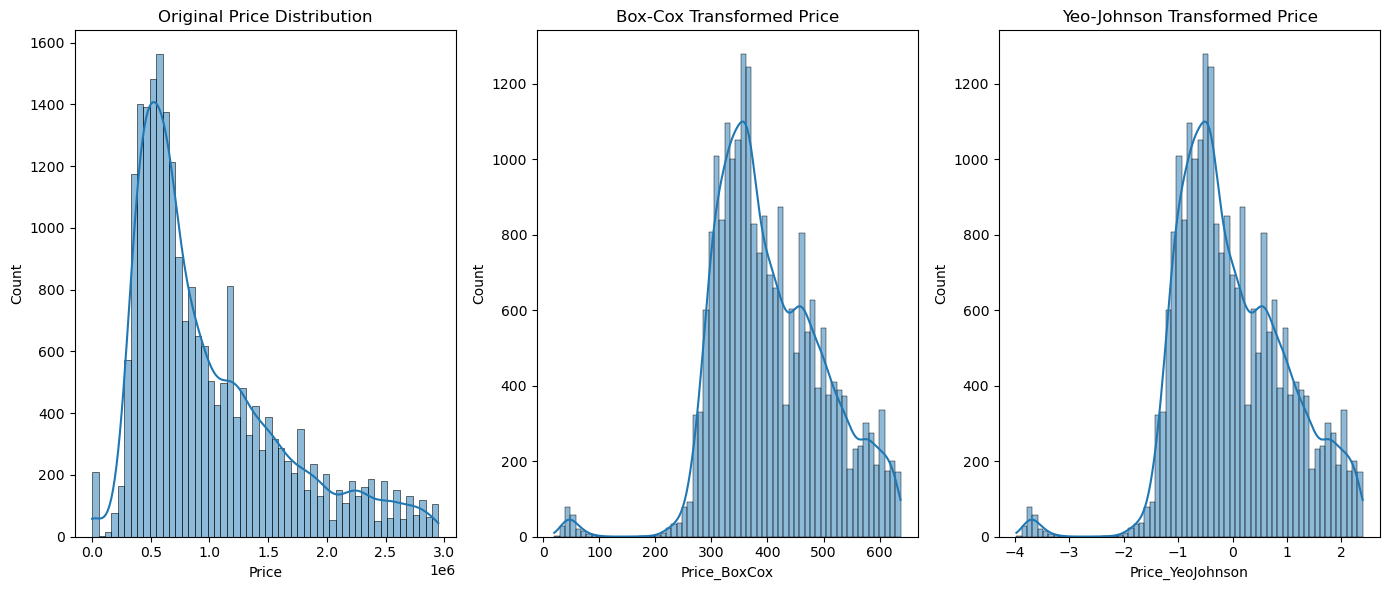

In [13]:
# Box-Cox Transformation (Note: Box-Cox requires strictly positive data)
data_cleaned['Price_BoxCox'], _ = boxcox(data_cleaned['Price'] + 1)  # Adding 1 to handle zero values
#data_cleaned['Price'] = data_cleaned['Price_BoxCox']

# Yeo-Johnson Transformation
pt = PowerTransformer(method='yeo-johnson')
data_cleaned['Price_YeoJohnson'] = pt.fit_transform(data_cleaned[['Price']])

# Check skewness after transformations
boxcox_skewness = skew(data_cleaned['Price_BoxCox'])
yeojohnson_skewness = skew(data_cleaned['Price_YeoJohnson'])
print(f'Box-Cox Skewness: {boxcox_skewness}')
print(f'Yeo-Johnson Skewness: {yeojohnson_skewness}')

# Plotting to visualize the effect of transformations
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.histplot(data_cleaned['Price'], kde=True)
plt.title('Original Price Distribution')

plt.subplot(1, 3, 2)
sns.histplot(data_cleaned['Price_BoxCox'], kde=True)
plt.title('Box-Cox Transformed Price')

plt.subplot(1, 3, 3)
sns.histplot(data_cleaned['Price_YeoJohnson'], kde=True)
plt.title('Yeo-Johnson Transformed Price')

plt.tight_layout()
plt.show()

data_cleaned.drop(columns=['Price_BoxCox'], inplace=True)
data_cleaned.drop(columns=['Price_YeoJohnson'], inplace=True)


In [14]:
# Unique property types
unique_property_types = data_cleaned['Property Type'].unique()

print("Unique Property Types:")
for prop_type in unique_property_types:
    print(prop_type)

Unique Property Types:
Serviced Residence
Condominium (Corner)
Apartment (Intermediate)
Serviced Residence (Intermediate)
Condominium
Condominium (Intermediate)
Condominium (EndLot)
Serviced Residence (Corner)
Serviced Residence (Duplex)
3-sty Terrace/Link House (Intermediate)
Serviced Residence (EndLot)
2-sty Terrace/Link House (Intermediate)
Townhouse
Apartment (Corner)
Semi-detached House
Apartment
Townhouse (Intermediate)
Serviced Residence (Penthouse)
Condominium (Duplex)
3-sty Terrace/Link House
2-sty Terrace/Link House
3.5-sty Terrace/Link House (Corner)
Serviced Residence (SOHO)
2.5-sty Terrace/Link House
3-sty Terrace/Link House (EndLot)
Flat (Intermediate)
Townhouse (EndLot)
2.5-sty Terrace/Link House (Intermediate)
2-sty Terrace/Link House (Corner)
3-sty Terrace/Link House (Corner)
3-sty Terrace/Link House (Duplex)
Condominium (Penthouse)
Semi-detached House (Intermediate)
Flat (Corner)
Apartment (EndLot)
Condominium (SOHO)
2-sty Terrace/Link House (EndLot)
3.5-sty Terrace/L

In [15]:
# Unique property types
unique_property_types = data_cleaned['Location'].unique()

print("Unique Location:")
for prop_type in unique_property_types:
    print(prop_type)

Unique Location:
KLCC, Kuala Lumpur
Dutamas, Kuala Lumpur
Bukit Jalil, Kuala Lumpur
Sri Petaling, Kuala Lumpur
Mont Kiara, Kuala Lumpur
Desa ParkCity, Kuala Lumpur
Damansara Heights, Kuala Lumpur
Bangsar South, Kuala Lumpur
Ampang Hilir, Kuala Lumpur
Jalan Klang Lama (Old Klang Road), Kuala Lumpur
KL City, Kuala Lumpur
Sungai Besi, Kuala Lumpur
Setapak, Kuala Lumpur
City Centre, Kuala Lumpur
KL Sentral, Kuala Lumpur
Taman Desa, Kuala Lumpur
Sentul, Kuala Lumpur
Segambut, Kuala Lumpur
Wangsa Maju, Kuala Lumpur
Batu Caves, Kuala Lumpur
Bangsar, Kuala Lumpur
Klcc, Kuala Lumpur
Setiawangsa, Kuala Lumpur
Chan Sow Lin, Kuala Lumpur
Taman Tun Dr Ismail, Kuala Lumpur
Jalan Kuching, Kuala Lumpur
Cheras, Kuala Lumpur
Ampang, Kuala Lumpur
KL Eco City, Kuala Lumpur
Bukit Bintang, Kuala Lumpur
Kuchai Lama, Kuala Lumpur
Kepong, Kuala Lumpur
Bandar Menjalara, Kuala Lumpur
Seputeh, Kuala Lumpur
Jalan Ipoh, Kuala Lumpur
Bukit Tunku (Kenny Hills), Kuala Lumpur
Desa Pandan, Kuala Lumpur
Desa Petaling, Ku

In [16]:
# Count of each property type
property_type_counts = data_cleaned['Property Type'].value_counts()

print("Count of Each Property Type:")
print(property_type_counts)

Count of Each Property Type:
Property Type
Condominium                            6158
Condominium (Corner)                   3698
Condominium (Intermediate)             3665
Serviced Residence                     3482
Serviced Residence (Intermediate)      2058
                                       ... 
Bungalow (Intermediate)                   1
4.5-sty Terrace/Link House                1
2-sty Terrace/Link House (Duplex)         1
1.5-sty Terrace/Link House (EndLot)       1
Apartment (Triplex)                       1
Name: count, Length: 69, dtype: int64


In [17]:
# Display the first few rows to verify import
print("Initial DataFrame:")
print(data_cleaned)

# Step 2: Define the mapping of specific property types to broad categories
property_type_mapping = {
    'Serviced Residence': 'Serviced Residence',
    'Serviced Residence (Corner)': 'Serviced Residence',
    'Serviced Residence (Intermediate)': 'Serviced Residence',
    'Serviced Residence (Duplex)': 'Serviced Residence',
    'Serviced Residence (EndLot)': 'Serviced Residence',
    'Serviced Residence (Penthouse)': 'Serviced Residence',
    'Serviced Residence (SOHO)': 'Serviced Residence',
    'Serviced Residence (Studio)': 'Serviced Residence',
    'Serviced Residence (Triplex)': 'Serviced Residence',
    
    'Condominium': 'Condo',
    'Condominium (Corner)': 'Condo',
    'Condominium (Intermediate)': 'Condo',
    'Condominium (EndLot)': 'Condo',
    'Condominium (Duplex)': 'Condo',
    'Condominium (Penthouse)': 'Condo',
    'Condominium (SOHO)': 'Condo',
    'Condominium (Triplex)': 'Condo',
    'Condominium (Studio)': 'Condo',
    
    'Apartment': 'Apartment',
    'Apartment (Corner)': 'Apartment',
    'Apartment (Intermediate)': 'Apartment',
    'Apartment (EndLot)': 'Apartment',
    'Apartment (Duplex)': 'Apartment',
    'Apartment (Penthouse)': 'Apartment',
    'Apartment (Triplex)': 'Apartment',
    
    'Townhouse': 'Townhouse',
    'Townhouse (Corner)': 'Townhouse',
    'Townhouse (Intermediate)': 'Townhouse',
    'Townhouse (EndLot)': 'Townhouse',
    'Townhouse (Duplex)': 'Townhouse',
    
    '1-sty Terrace/Link House': 'Terrace/Link House',
    '1-sty Terrace/Link House (Corner)': 'Terrace/Link House',
    '1-sty Terrace/Link House (Intermediate)': 'Terrace/Link House',
    '1-sty Terrace/Link House (EndLot)': 'Terrace/Link House',
    '2-sty Terrace/Link House': 'Terrace/Link House',
    '2-sty Terrace/Link House (Corner)': 'Terrace/Link House',
    '2-sty Terrace/Link House (Intermediate)': 'Terrace/Link House',
    '2-sty Terrace/Link House (EndLot)': 'Terrace/Link House',
    '2-sty Terrace/Link House (Duplex)': 'Terrace/Link House',
    '3-sty Terrace/Link House': 'Terrace/Link House',
    '3-sty Terrace/Link House (Corner)': 'Terrace/Link House',
    '3-sty Terrace/Link House (Intermediate)': 'Terrace/Link House',
    '3-sty Terrace/Link House (EndLot)': 'Terrace/Link House',
    '3-sty Terrace/Link House (Duplex)': 'Terrace/Link House',
    '3.5-sty Terrace/Link House': 'Terrace/Link House',
    '3.5-sty Terrace/Link House (Corner)': 'Terrace/Link House',
    '4-sty Terrace/Link House': 'Terrace/Link House',
    '4-sty Terrace/Link House (Corner)': 'Terrace/Link House',
    '4-sty Terrace/Link House (Intermediate)': 'Terrace/Link House',
    '4.5-sty Terrace/Link House': 'Terrace/Link House',
    '4.5-sty Terrace/Link House (Intermediate)': 'Terrace/Link House',
    '2.5-sty Terrace/Link House': 'Terrace/Link House',
    '2.5-sty Terrace/Link House (Corner)': 'Terrace/Link House',
    '2.5-sty Terrace/Link House (Intermediate)': 'Terrace/Link House',
    '1.5-sty Terrace/Link House': 'Terrace/Link House',
    '1.5-sty Terrace/Link House (Corner)': 'Terrace/Link House',
    '1.5-sty Terrace/Link House (Intermediate)': 'Terrace/Link House',
    '1.5-sty Terrace/Link House (EndLot)': 'Terrace/Link House',
    
    'Semi-detached House': 'Semi-detached House',
    'Semi-detached House (Corner)': 'Semi-detached House',
    'Semi-detached House (Intermediate)': 'Semi-detached House',
    'Semi-detached House (EndLot)': 'Semi-detached House',
    
    'Bungalow': 'Bungalow',
    'Bungalow (Corner)': 'Bungalow',
    'Bungalow (Intermediate)': 'Bungalow',
    
    'Residential Land': 'Residential Land',
    
    'Flat': 'Flat',
    'Flat (Intermediate)': 'Flat',
    'Flat (Corner)': 'Flat',
    'Flat (EndLot)': 'Flat'
}

# Step 3: Apply the mapping to the 'Property Type' column
data_cleaned['Broad Property Type'] = data_cleaned['Property Type'].replace(property_type_mapping)

# Display unique values in the new 'Broad Property Type' column
unique_broad_types = data_cleaned['Broad Property Type'].unique()
print("Unique Broad Property Types after mapping:")
print(unique_broad_types)


Initial DataFrame:
                         Location    Price  Rooms  Bathrooms  Car Parks  \
0              KLCC, Kuala Lumpur  1250000      3        3.0          2   
2           Dutamas, Kuala Lumpur  1030000      3        4.0          2   
4       Bukit Jalil, Kuala Lumpur   900000      5        3.0          2   
9      Sri Petaling, Kuala Lumpur   385000      3        2.0          1   
18       Mont Kiara, Kuala Lumpur  1780000      5        4.0          2   
...                           ...      ...    ...        ...        ...   
53860        Ampang, Kuala Lumpur   490000      1        1.0          1   
53862       Seputeh, Kuala Lumpur   750000      3        2.0          1   
53869   KL Eco City, Kuala Lumpur   880000      1        1.0          1   
53876  Sri Hartamas, Kuala Lumpur  2700000      6        6.0          3   
53882       Setapak, Kuala Lumpur   540000      4        2.0          3   

                    Property Type  Size        Furnishing  
0              Servi

In [18]:
# Count of each property type
property_type_counts = data_cleaned['Broad Property Type'].value_counts()

print("Count of Each Property Type:")
print(property_type_counts)

Count of Each Property Type:
Broad Property Type
Condo                  14018
Serviced Residence      7167
Apartment                999
Terrace/Link House       403
Townhouse                189
Flat                      95
Semi-detached House       43
Bungalow                   8
Residential Land           2
Name: count, dtype: int64


In [19]:
# Manually provided locations dictionary
# Updated locations dictionary
locations = {
    'KLCC, Kuala Lumpur': [3.1578, 101.7123],
    'Dutamas, Kuala Lumpur': [3.1822, 101.6654],
    'Bukit Jalil, Kuala Lumpur': [3.0593, 101.6895],
    'Sri Petaling, Kuala Lumpur': [3.0671, 101.6901],
    'Mont Kiara, Kuala Lumpur': [3.1718, 101.6501],
    'Desa ParkCity, Kuala Lumpur': [3.1865, 101.6341],
    'Damansara Heights, Kuala Lumpur': [3.1412, 101.6618],
    'Bangsar South, Kuala Lumpur': [3.1124, 101.6654],
    'Ampang Hilir, Kuala Lumpur': [3.1532, 101.7475],
    'Jalan Klang Lama (Old Klang Road), Kuala Lumpur': [3.0925, 101.6748],
    'KL City, Kuala Lumpur': [3.1543, 101.7155],
    'Sungai Besi, Kuala Lumpur': [3.0645, 101.7162],
    'Setapak, Kuala Lumpur': [3.2061, 101.7271],
    'City Centre, Kuala Lumpur': [3.1554, 101.7140],
    'KL Sentral, Kuala Lumpur': [3.1328, 101.6851],
    'Taman Desa, Kuala Lumpur': [3.1026, 101.6857],
    'Sentul, Kuala Lumpur': [3.1890, 101.6896],
    'Segambut, Kuala Lumpur': [3.1890, 101.6628],
    'Wangsa Maju, Kuala Lumpur': [3.2041, 101.7372],
    'Batu Caves, Kuala Lumpur': [3.2360, 101.6841],
    'Bangsar, Kuala Lumpur': [3.1283, 101.6793],
    'Klcc, Kuala Lumpur': [3.1588, 101.7133],
    'Setiawangsa, Kuala Lumpur': [3.1814, 101.7351],
    'Chan Sow Lin, Kuala Lumpur': [3.1224, 101.7146],
    'Taman Tun Dr Ismail, Kuala Lumpur': [3.1518, 101.6292],
    'Jalan Kuching, Kuala Lumpur': [3.1864, 101.6752],
    'Cheras, Kuala Lumpur': [3.0958, 101.7405],
    'Ampang, Kuala Lumpur': [3.1589, 101.7615],
    'KL Eco City, Kuala Lumpur': [3.1173, 101.6757],
    'Bukit Bintang, Kuala Lumpur': [3.1466, 101.7093],
    'Kuchai Lama, Kuala Lumpur': [3.0922, 101.6862],
    'Kepong, Kuala Lumpur': [3.2126, 101.6370],
    'Bandar Menjalara, Kuala Lumpur': [3.2015, 101.6295],
    'Seputeh, Kuala Lumpur': [3.1188, 101.6832],
    'Jalan Ipoh, Kuala Lumpur': [3.1934, 101.6761],
    'Bukit Tunku (Kenny Hills), Kuala Lumpur': [3.1618, 101.6835],
    'Desa Pandan, Kuala Lumpur': [3.1468, 101.7375],
    'Desa Petaling, Kuala Lumpur': [3.0853, 101.7047],
    'Taman Melawati, Kuala Lumpur': [3.2117, 101.7512],
    'Pantai, Kuala Lumpur': [3.1136, 101.6633],
    'Sri Hartamas, Kuala Lumpur': [3.1665, 101.6575],
    'Sunway SPK, Kuala Lumpur': [3.1905, 101.6378],
    'Brickfields, Kuala Lumpur': [3.1291, 101.6838],
    'OUG, Kuala Lumpur': [3.0786, 101.6783],
    'Salak Selatan, Kuala Lumpur': [3.0905, 101.7044],
    'Titiwangsa, Kuala Lumpur': [3.1752, 101.7038],
    'Pandan Perdana, Kuala Lumpur': [3.1251, 101.7425],
    'Jalan Sultan Ismail, Kuala Lumpur': [3.1536, 101.7055],
    'Mid Valley City, Kuala Lumpur': [3.1180, 101.6744],
    'Keramat, Kuala Lumpur': [3.1620, 101.7378],
    'Jinjang, Kuala Lumpur': [3.2174, 101.6526],
    'Bandar Tasik Selatan, Kuala Lumpur': [3.0658, 101.7174],
    'Pandan Jaya, Kuala Lumpur': [3.1285, 101.7426],
    'Country Heights Damansara, Kuala Lumpur': [3.1801, 101.6301],
    'Bandar Damai Perdana, Kuala Lumpur': [3.0602, 101.7381],
    'Bukit Ledang, Kuala Lumpur': [3.1552, 101.6786],
    'Pandan Indah, Kuala Lumpur': [3.1266, 101.7494],
    'Puchong, Kuala Lumpur': [3.0350, 101.6199],
    'Damansara, Kuala Lumpur': [3.1368, 101.6168],
    'Sungai Penchala, Kuala Lumpur': [3.1591, 101.6211],
    'Taman Duta, Kuala Lumpur': [3.1593, 101.6752],
}

# Function to add latitude and longitude to DataFrame
def add_lat_lon(row):
    location = row['Location']
    if location in locations:
        return pd.Series(locations[location], index=['Latitude', 'Longitude'])
    else:
        return pd.Series([None, None], index=['Latitude', 'Longitude'])

# Add latitude and longitude columns to the DataFrame
data_cleaned[['Latitude', 'Longitude']] = data_cleaned.apply(add_lat_lon, axis=1)

# Display the updated DataFrame
print(data_cleaned)

                         Location    Price  Rooms  Bathrooms  Car Parks  \
0              KLCC, Kuala Lumpur  1250000      3        3.0          2   
2           Dutamas, Kuala Lumpur  1030000      3        4.0          2   
4       Bukit Jalil, Kuala Lumpur   900000      5        3.0          2   
9      Sri Petaling, Kuala Lumpur   385000      3        2.0          1   
18       Mont Kiara, Kuala Lumpur  1780000      5        4.0          2   
...                           ...      ...    ...        ...        ...   
53860        Ampang, Kuala Lumpur   490000      1        1.0          1   
53862       Seputeh, Kuala Lumpur   750000      3        2.0          1   
53869   KL Eco City, Kuala Lumpur   880000      1        1.0          1   
53876  Sri Hartamas, Kuala Lumpur  2700000      6        6.0          3   
53882       Setapak, Kuala Lumpur   540000      4        2.0          3   

                    Property Type  Size        Furnishing Broad Property Type  \
0              Ser

In [20]:
# Drop rows where size > 10000
data_cleaned = data_cleaned[data_cleaned['Size'] <= 10000]

# Display cleaned DataFrame
print("\nCleaned DataFrame:")
print(data_cleaned)


Cleaned DataFrame:
                         Location    Price  Rooms  Bathrooms  Car Parks  \
0              KLCC, Kuala Lumpur  1250000      3        3.0          2   
2           Dutamas, Kuala Lumpur  1030000      3        4.0          2   
4       Bukit Jalil, Kuala Lumpur   900000      5        3.0          2   
9      Sri Petaling, Kuala Lumpur   385000      3        2.0          1   
18       Mont Kiara, Kuala Lumpur  1780000      5        4.0          2   
...                           ...      ...    ...        ...        ...   
53860        Ampang, Kuala Lumpur   490000      1        1.0          1   
53862       Seputeh, Kuala Lumpur   750000      3        2.0          1   
53869   KL Eco City, Kuala Lumpur   880000      1        1.0          1   
53876  Sri Hartamas, Kuala Lumpur  2700000      6        6.0          3   
53882       Setapak, Kuala Lumpur   540000      4        2.0          3   

                    Property Type  Size        Furnishing Broad Property Type  

In [21]:
# Inspect the unique values in the 'furnishing' column to identify unknown values
print("Unique values in 'furnishing' column:")
print(data_cleaned['Furnishing'].unique())

# Define a list of values to be considered as unknown
unknown_values = ['Unknown', 'N/A', 'Other']

# Drop rows where 'furnishing' column contains any of the unknown values
data_cleaned = data_cleaned[~data_cleaned['Furnishing'].isin(unknown_values)]

# Verify the cleaning
print("\nUnique values in 'furnishing' column after dropping unknowns:")
print(data_cleaned['Furnishing'].unique())
print("\nNumber of rows after dropping unknowns:")
print(data_cleaned.shape[0])

Unique values in 'furnishing' column:
['Fully Furnished' 'Partly Furnished' 'Unknown' 'Unfurnished']

Unique values in 'furnishing' column after dropping unknowns:
['Fully Furnished' 'Partly Furnished' 'Unfurnished']

Number of rows after dropping unknowns:
22786


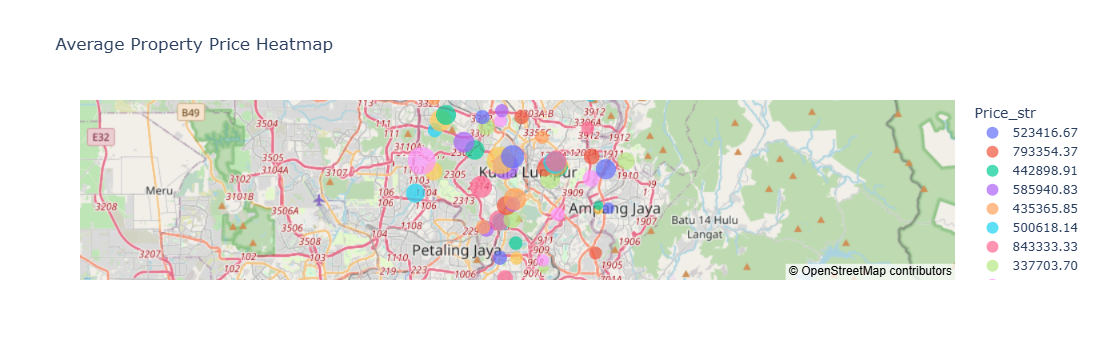

In [22]:
# Compute the average price for each location
average_price_df = data_cleaned.groupby(['Latitude', 'Longitude', 'Location']).agg({'Price': 'mean'}).reset_index()

# Format prices to two decimal places and convert to strings
average_price_df['Price_str'] = average_price_df['Price'].apply(lambda x: f'{x:.2f}')

# Create a scatter map with unique colors for each average price
fig = px.scatter_mapbox(average_price_df, lat='Latitude', lon='Longitude', color='Price_str', size='Price',
                        mapbox_style="open-street-map", zoom=10, center={'lat': 3.1390, 'lon': 101.6869},
                        hover_name='Location', hover_data={'Price': ':.2f', 'Latitude': False, 'Longitude': False},
                        title="Average Property Price Heatmap")

# Display the figure
fig.show()

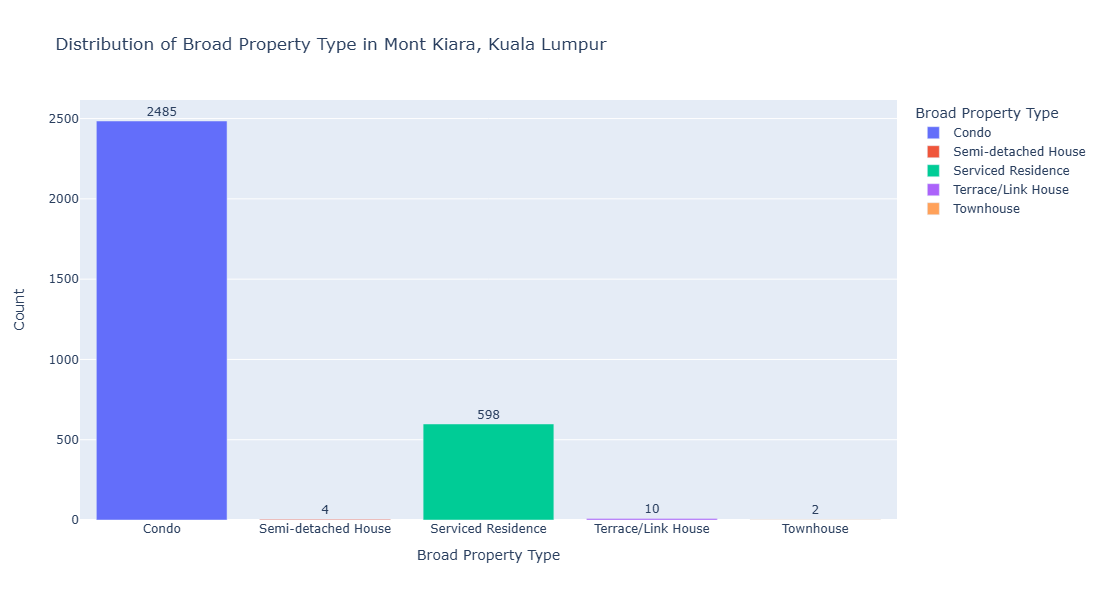

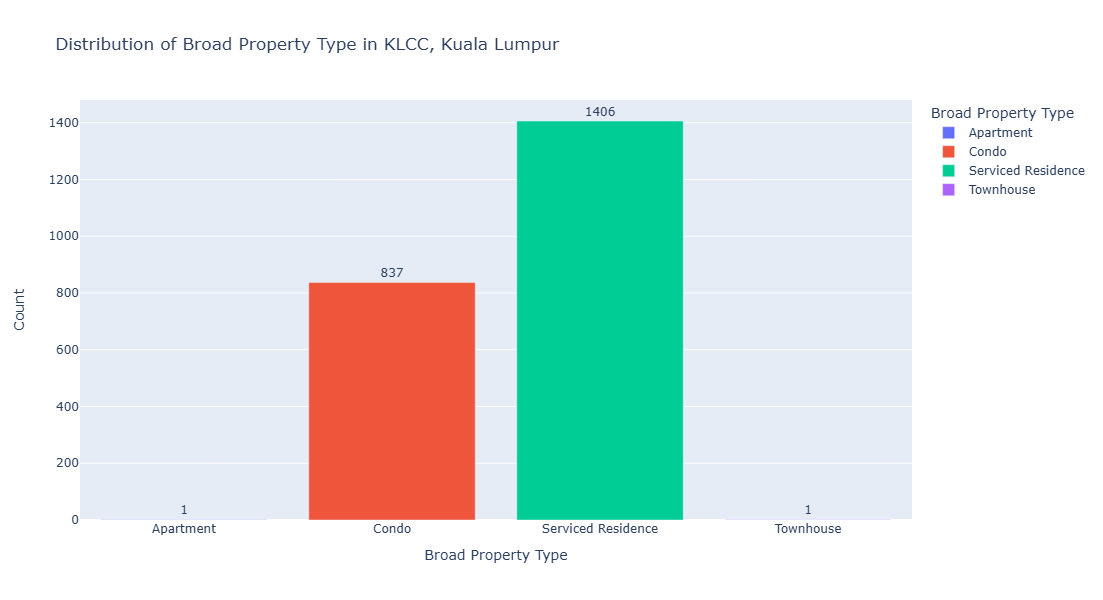

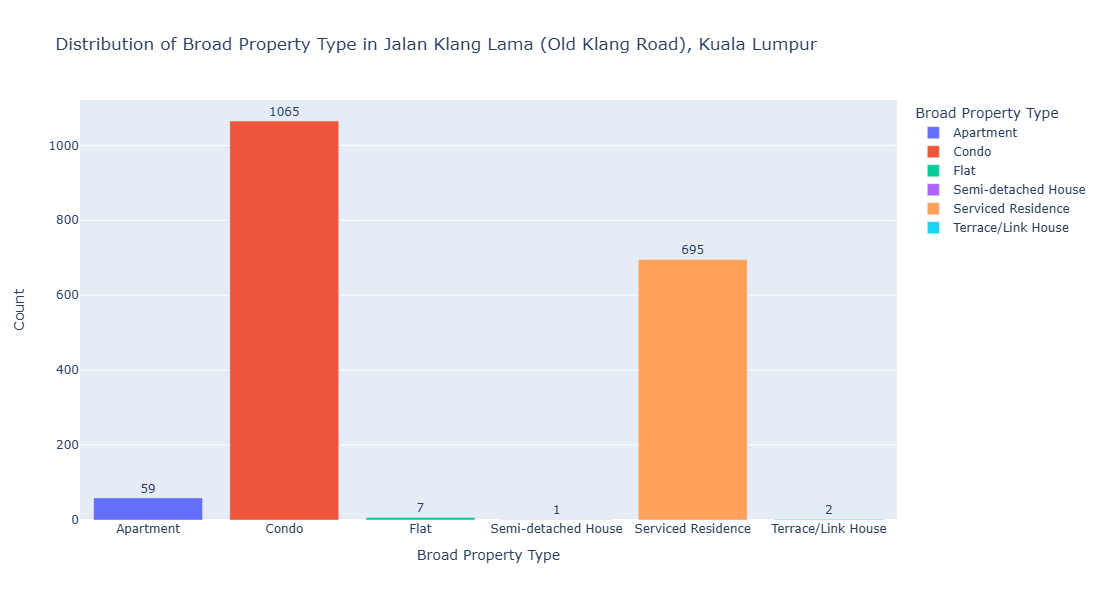

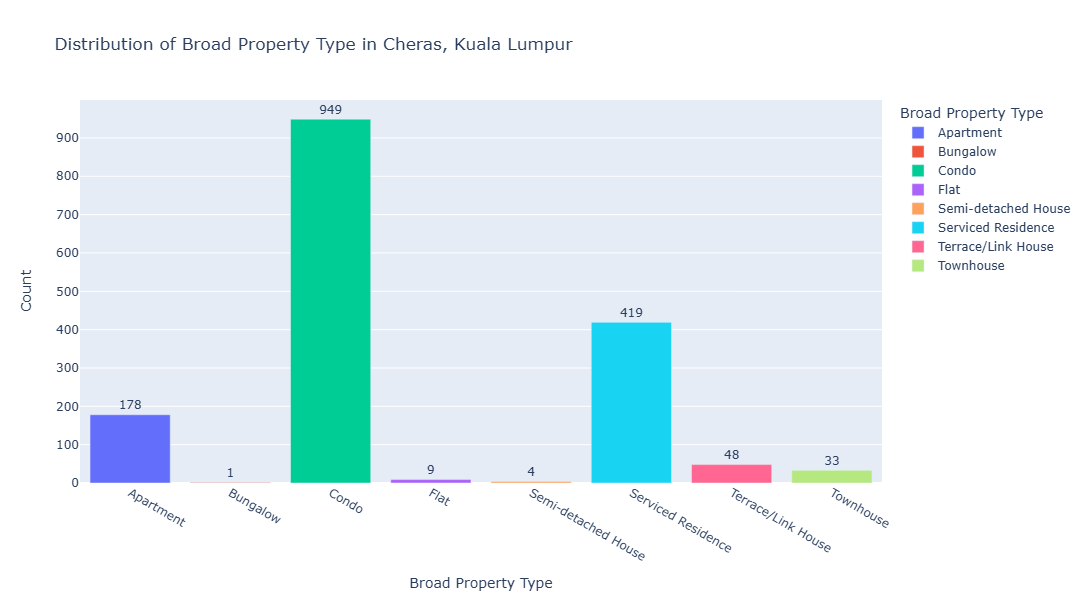

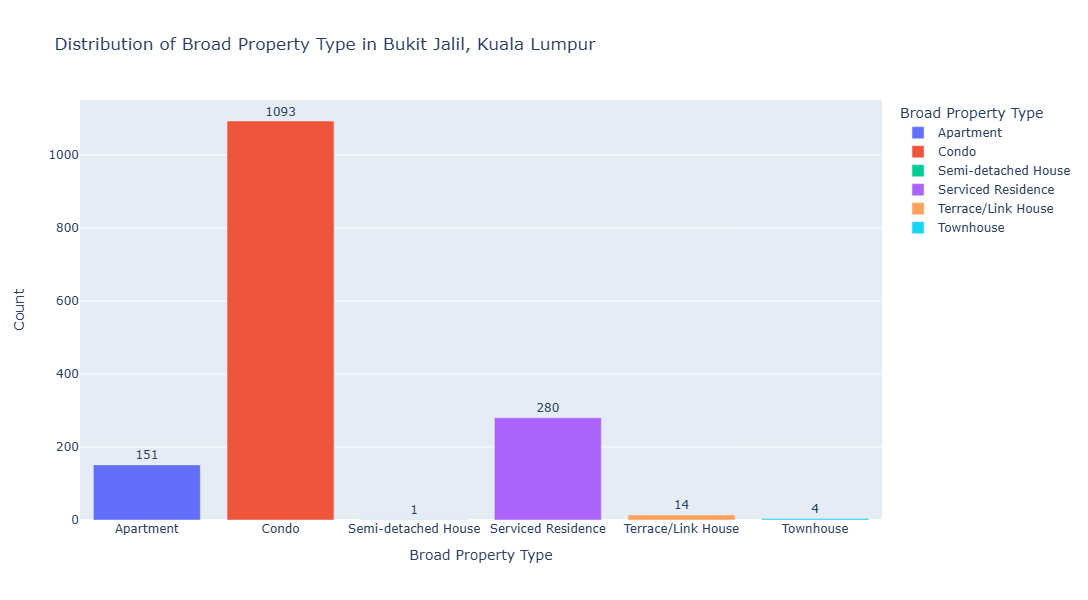

In [23]:
import plotly.express as px

# Get the top 5 locations based on the count of properties
top_5_locations = data_cleaned['Location'].value_counts().index[:5]

# Filter the DataFrame to include only the top 5 locations
filtered_df = data_cleaned[data_cleaned['Location'].isin(top_5_locations)]

# Aggregate the data to get the total count of each Broad Property Type for each location
agg_df = filtered_df.groupby(['Location', 'Broad Property Type']).size().reset_index(name='Count')

# Create a dictionary to hold the figures
figures = {}

# Generate and store a plot for each location
for location in top_5_locations:
    loc_data = agg_df[agg_df['Location'] == location]
    fig = px.bar(loc_data, x='Broad Property Type', y='Count', color='Broad Property Type', 
                 title=f'Distribution of Broad Property Type in {location}',
                 labels={'Broad Property Type': 'Broad Property Type', 'Count': 'Count'},
                 color_discrete_sequence=px.colors.qualitative.Plotly)
    fig.update_layout(
        xaxis_title='Broad Property Type', 
        yaxis_title='Count',
        height=600  # Adjust height as needed
    )
    fig.update_traces(texttemplate='%{y}', textposition='outside')
    
    # Add the figure to the dictionary
    figures[location] = fig

# Display the figures
for location, fig in figures.items():
    fig.show()


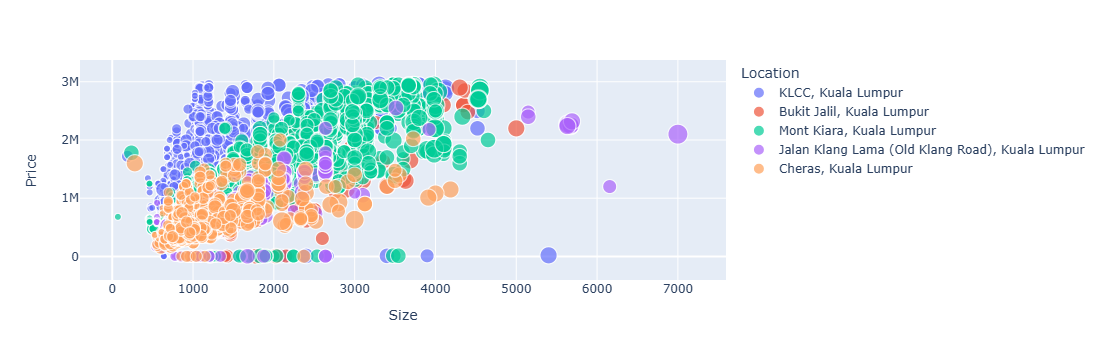

In [24]:
# Calculate the top 5 locations by count
top_5_locations = data_cleaned['Location'].value_counts().head(5).index

# Filter the DataFrame to include only the top 5 locations
filtered_df = data_cleaned[data_cleaned['Location'].isin(top_5_locations)]

# Create the scatter plot
fig = px.scatter(filtered_df, x='Size', y='Price', color='Location', size='Rooms',
                 hover_data=['Location', 'Price', 'Size', 'Rooms'])

# Display the figure
fig.show()

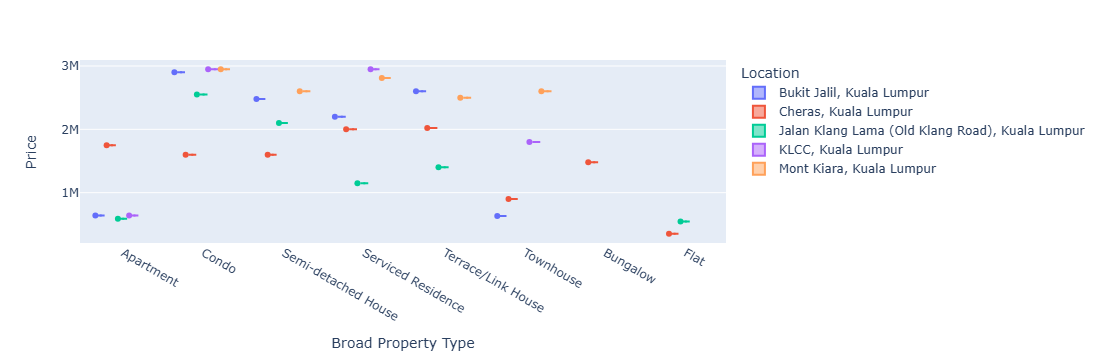

In [25]:
# Find the top 5 locations by count
top_locations = data_cleaned['Location'].value_counts().nlargest(5).index

# Filter the DataFrame to include only the top 5 locations
df_top_locations = data_cleaned[data_cleaned['Location'].isin(top_locations)]

# For each combination of location and broad property type, select the row with the highest price
df_highest_price = df_top_locations.loc[df_top_locations.groupby(['Location', 'Broad Property Type'])['Price'].idxmax()]

fig = px.violin(df_highest_price, y='Price', x='Broad Property Type', color='Location', box=True, points='all')

fig.show()

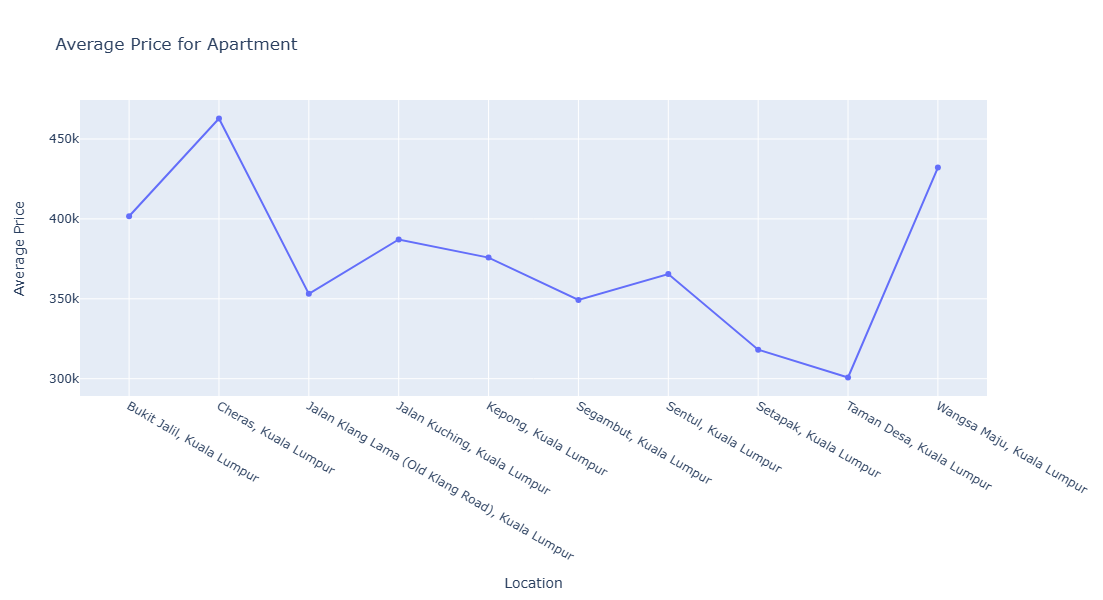

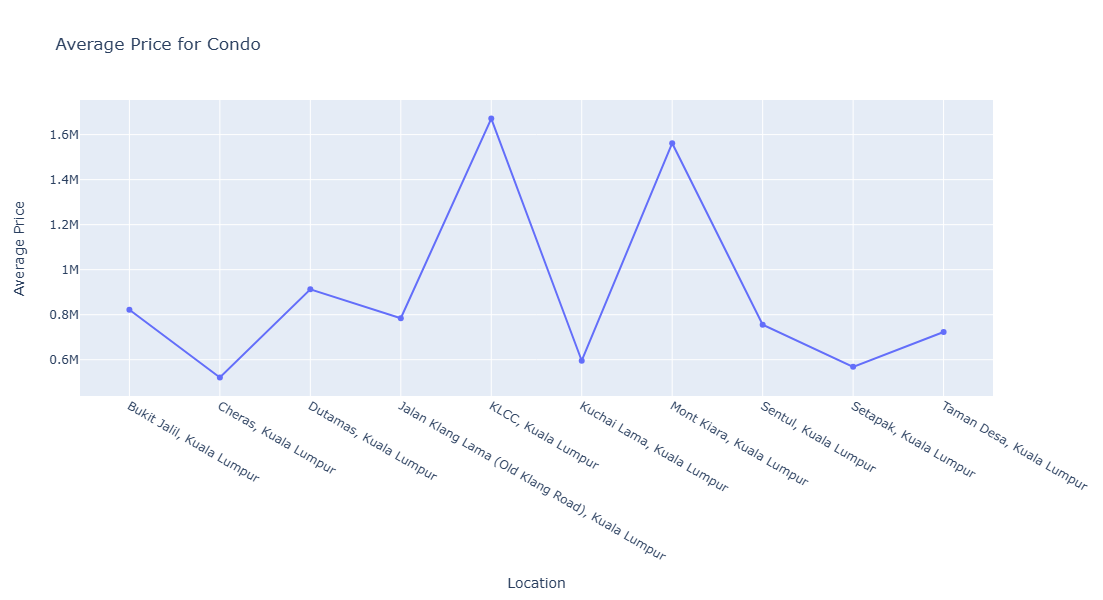

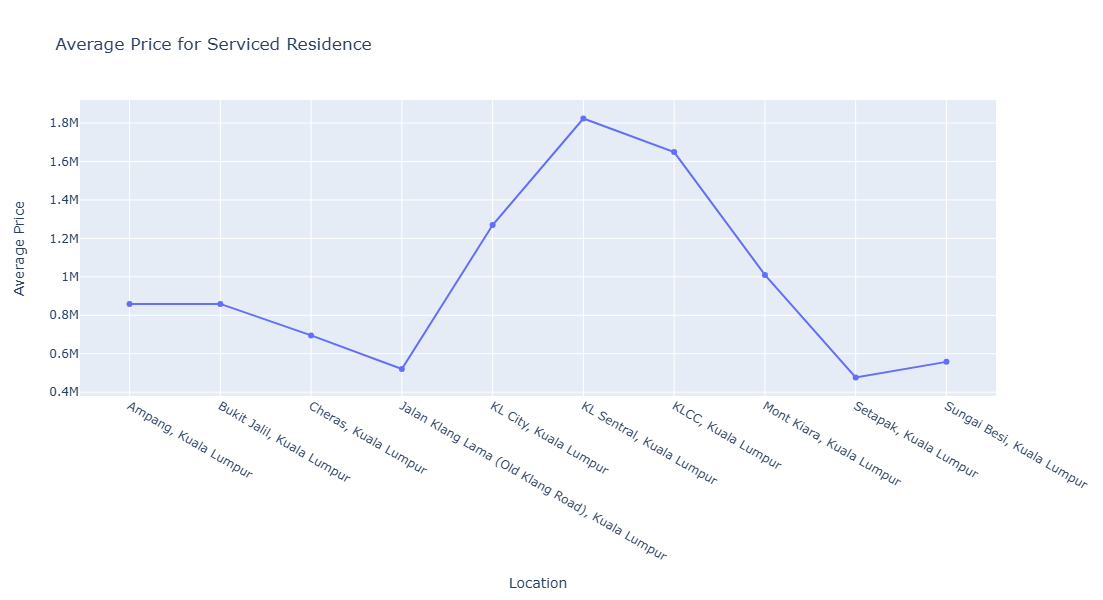

In [26]:
# Define the broad property types of interest
property_types_of_interest = ['Apartment', 'Condo', 'Serviced Residence']

# Create a dictionary to hold the figures
figures = {}

for prop_type in property_types_of_interest:
    # Filter data for the current property type
    df_prop_type = data_cleaned[data_cleaned['Broad Property Type'] == prop_type]
    
    # Find the top 10 locations by count for the current property type
    top_locations = df_prop_type['Location'].value_counts().nlargest(10).index
    
    # Filter the DataFrame to include only the top 10 locations
    df_top_locations = df_prop_type[df_prop_type['Location'].isin(top_locations)]
    
    # Calculate the average price for each combination of Location and Broad Property Type
    average_prices = df_top_locations.groupby(['Location'])['Price'].mean().reset_index()
    
    # Sort locations to make the line plot coherent
    average_prices = average_prices.sort_values(by='Location')
    
    # Create a line plot for the current property type
    fig = px.line(average_prices, x='Location', y='Price', 
                  title=f"Average Price for {prop_type}",
                  labels={'Price': 'Average Price', 'Location': 'Location'},
                  markers=True)
    
    # Update the layout to make the figure larger
    fig.update_layout(width=1000, height=600)
    
    # Add the figure to the dictionary
    figures[prop_type] = fig

# Display the figures
for prop_type, fig in figures.items():
    fig.show()

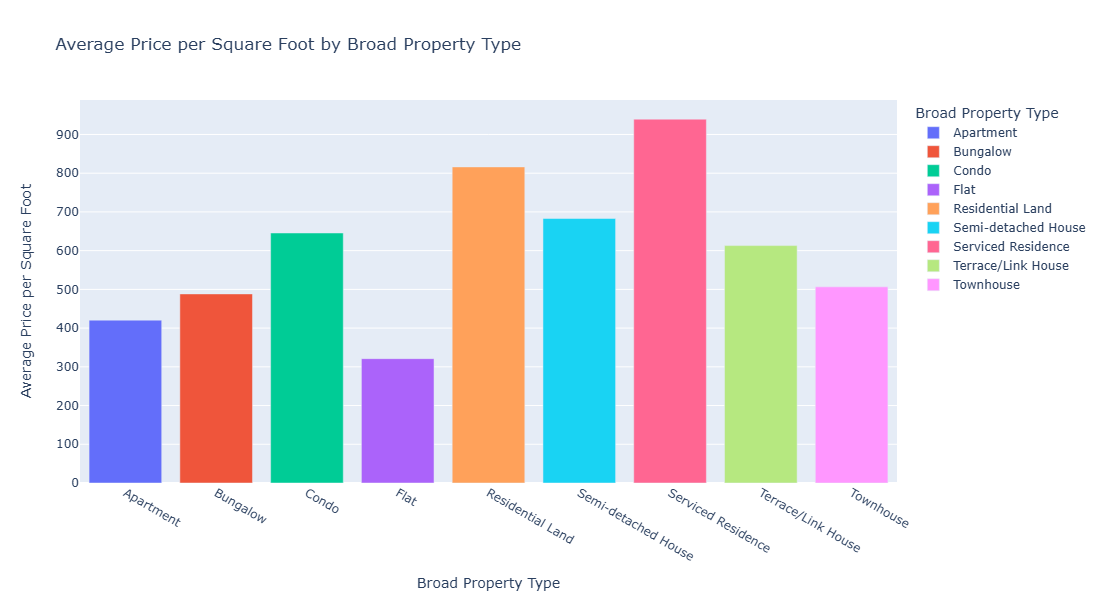

In [27]:
# Calculate Price per Square Foot
data_cleaned['Price per Sq Ft'] = data_cleaned['Price'] / data_cleaned['Size']

# Calculate the average Price per Square Foot by Broad Property Type
avg_price_per_sqft = data_cleaned.groupby('Broad Property Type')['Price per Sq Ft'].mean().reset_index()

# Create a bar plot
fig = px.bar(avg_price_per_sqft, x='Broad Property Type', y='Price per Sq Ft',
             title="Average Price per Square Foot by Broad Property Type",
             labels={'Price per Sq Ft': 'Average Price per Square Foot', 'Broad Property Type': 'Broad Property Type'},
             color='Broad Property Type')

# Update the layout to make the figure larger
fig.update_layout(width=1000, height=600)

data_cleaned.drop(columns=['Price per Sq Ft'], inplace=True)
# Display the figure
fig.show()

C:\Users\joone\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\joone\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



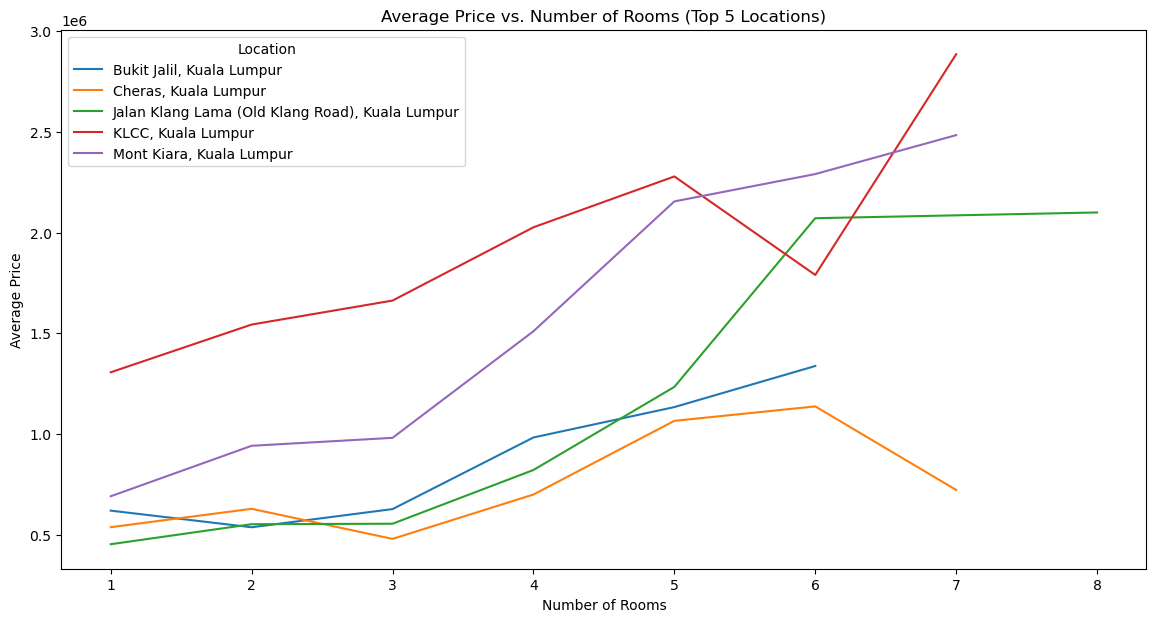

In [28]:
# Find the top 5 locations by count
top_locations = data_cleaned['Location'].value_counts().nlargest(5).index

# Filter the DataFrame to include only the top 5 locations
df_top_locations = data_cleaned[data_cleaned['Location'].isin(top_locations)]

# Compute the average price for each combination of location and number of rooms
avg_price_rooms = df_top_locations.groupby(['Location', 'Rooms'])['Price'].mean().reset_index()

# Set up the matplotlib figure
plt.figure(figsize=(14, 7))

# Create a line plot for the number of rooms vs. average price
sns.lineplot(data=avg_price_rooms, x='Rooms', y='Price', hue='Location', markers=True)

plt.title('Average Price vs. Number of Rooms (Top 5 Locations)')
plt.xlabel('Number of Rooms')
plt.ylabel('Average Price')
plt.legend(title='Location')

# Show the plot
plt.show()

C:\Users\joone\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\joone\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



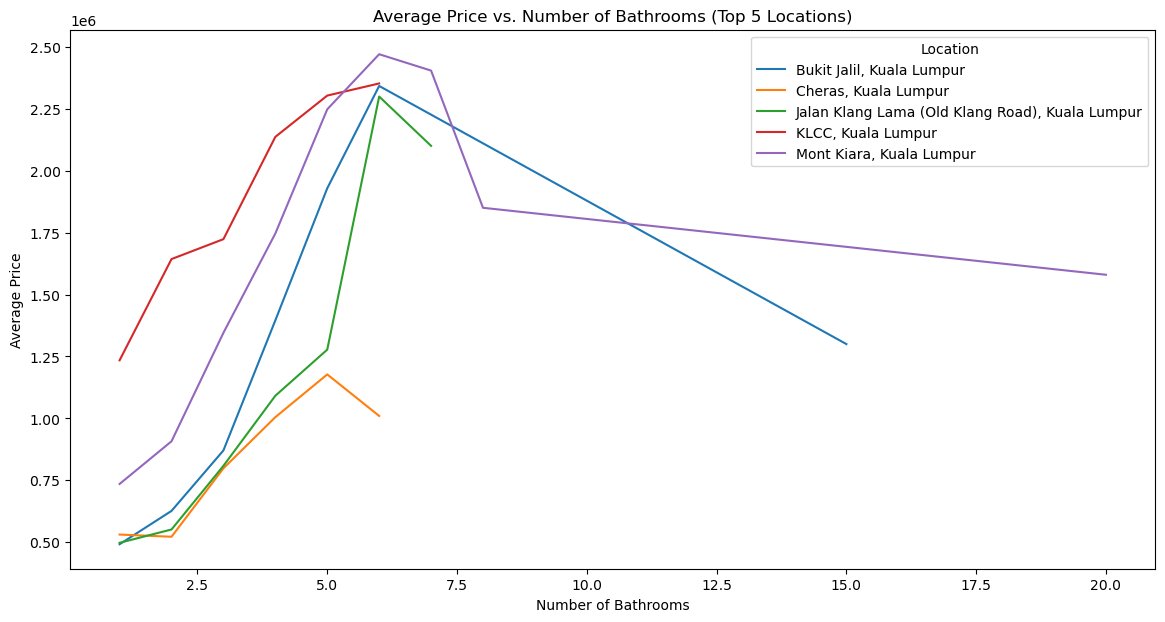

In [29]:
# Find the top 5 locations by count
top_locations = data_cleaned['Location'].value_counts().nlargest(5).index

# Filter the DataFrame to include only the top 5 locations
df_top_locations = data_cleaned[data_cleaned['Location'].isin(top_locations)]

# Compute the average price for each combination of location and number of bathrooms
avg_price_bathrooms = df_top_locations.groupby(['Location', 'Bathrooms'])['Price'].mean().reset_index()

# Set up the matplotlib figure
plt.figure(figsize=(14, 7))

# Create a line plot for the number of bathrooms vs. average price
sns.lineplot(data=avg_price_bathrooms, x='Bathrooms', y='Price', hue='Location', markers=True)

plt.title('Average Price vs. Number of Bathrooms (Top 5 Locations)')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Average Price')
plt.legend(title='Location')

# Show the plot
plt.show()

<Figure size 1200x800 with 0 Axes>

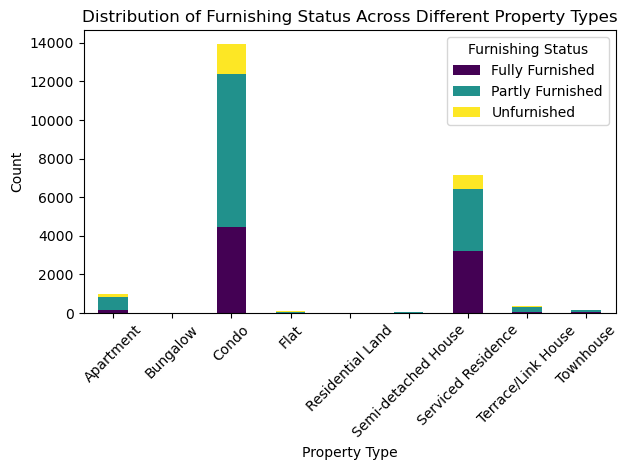

In [30]:
# Ensure the column names match your dataset
property_type_col = 'Broad Property Type'  # Adjust to your actual column name
furnishing_col = 'Furnishing'  # Adjust to your actual column name

# Calculate counts for each combination of property type and furnishing status
furnishing_distribution = data_cleaned.groupby([property_type_col, furnishing_col]).size().unstack().fillna(0)

# Remove property types with no data for furnishing status
furnishing_distribution = furnishing_distribution.loc[(furnishing_distribution.sum(axis=1) > 0)]

# Plotting
plt.figure(figsize=(12, 8))
furnishing_distribution.plot(kind='bar', stacked=True, colormap='viridis')

plt.title('Distribution of Furnishing Status Across Different Property Types')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.legend(title='Furnishing Status')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 1200x800 with 0 Axes>

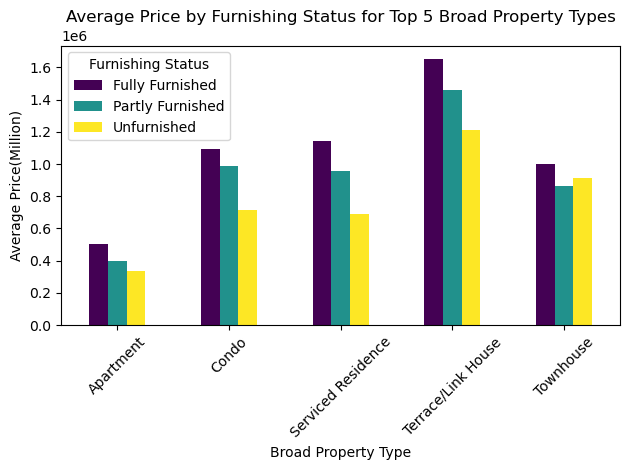

In [31]:
top_property_types = data_cleaned['Broad Property Type'].value_counts().nlargest(5).index
# Filter the DataFrame to include only the top 5 broad property types
df_top_property_types = data_cleaned[data_cleaned['Broad Property Type'].isin(top_property_types)]



# Calculate average prices by furnishing status for each property type
avg_price_by_furnishing = df_top_property_types.groupby(['Broad Property Type', 'Furnishing'])['Price'].mean().unstack().fillna(0)

# Plotting
plt.figure(figsize=(12, 8))
avg_price_by_furnishing.plot(kind='bar', colormap='viridis')

plt.title('Average Price by Furnishing Status for Top 5 Broad Property Types')
plt.xlabel('Broad Property Type')
plt.ylabel('Average Price(Million)')
plt.legend(title='Furnishing Status')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

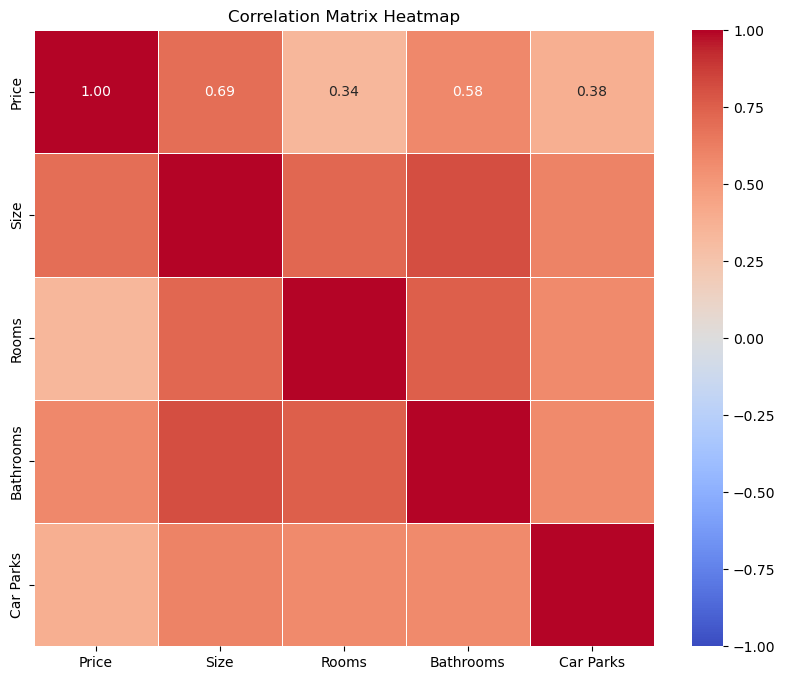

In [32]:
# Example columns: 'Price', 'Size', 'Rooms', 'Bathrooms', 'Car Parks'
numeric_columns = ['Price', 'Size', 'Rooms', 'Bathrooms', 'Car Parks']

# Convert columns to numeric if they are not already
data_cleaned[numeric_columns] = data_cleaned[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values in these columns
data_numeric = data_cleaned[numeric_columns].dropna()

# Compute the correlation matrix
correlation_matrix = data_numeric.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

Mean Squared Error: 21374.14
R² Score: 0.85


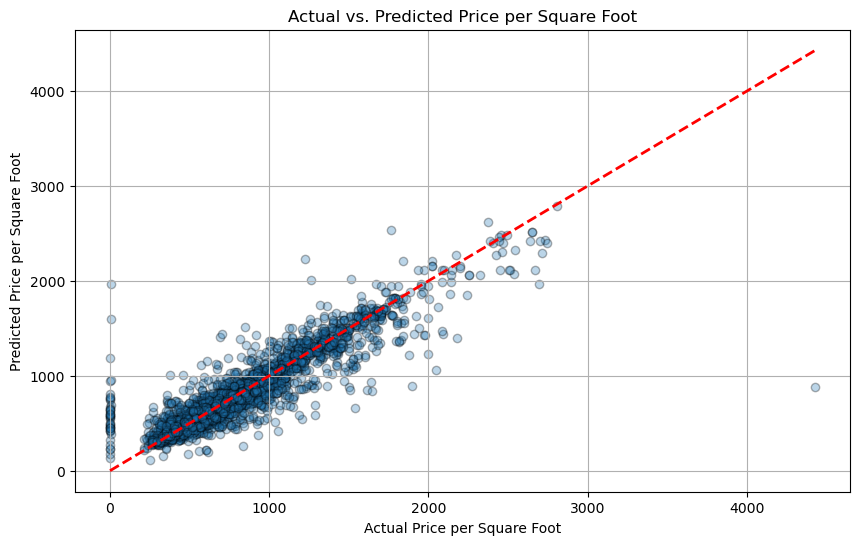

In [33]:
#Random Forest

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features and target
features = ['Size', 'Rooms', 'Bathrooms', 'Car Parks', 'Broad Property Type', 'Location', 'Furnishing']
X = data_cleaned[features]
y = data_cleaned['Price'] / data_cleaned['Size']  # Price per square foot

# Convert features to numeric
X = X.copy()
X['Size'] = pd.to_numeric(X['Size'], errors='coerce')
X['Rooms'] = pd.to_numeric(X['Rooms'], errors='coerce')
X['Bathrooms'] = pd.to_numeric(X['Bathrooms'], errors='coerce')
X['Car Parks'] = pd.to_numeric(X['Car Parks'], errors='coerce')

# Handle categorical features
categorical_features = ['Broad Property Type', 'Location', 'Furnishing']
numeric_features = ['Size', 'Rooms', 'Bathrooms', 'Car Parks']

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline with preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Drop rows with missing values
X = X.dropna()
y = y[X.index]  # Ensure target and features have the same index

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Generate a scatter plot to visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.xlabel('Actual Price per Square Foot')
plt.ylabel('Predicted Price per Square Foot')
plt.title('Actual vs. Predicted Price per Square Foot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.grid(True)
plt.show()

Linear Regression - Mean Squared Error: 51377.95
Linear Regression - R² Score: 0.64


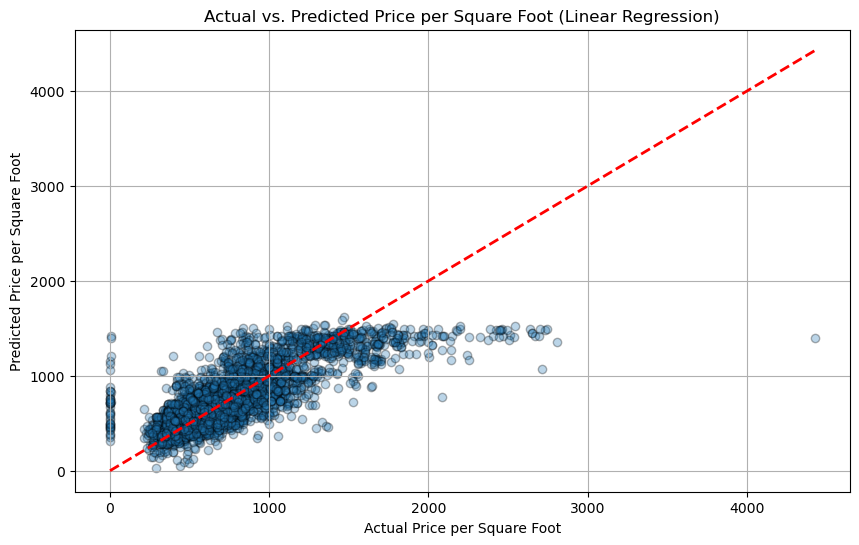

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define features and target
features = ['Size', 'Rooms', 'Bathrooms', 'Car Parks', 'Broad Property Type', 'Location', 'Furnishing']
X = data_cleaned[features]
y = data_cleaned['Price'] / data_cleaned['Size']  # Price per square foot

# Convert features to numeric
X = X.copy()
X['Size'] = pd.to_numeric(X['Size'], errors='coerce')
X['Rooms'] = pd.to_numeric(X['Rooms'], errors='coerce')
X['Bathrooms'] = pd.to_numeric(X['Bathrooms'], errors='coerce')
X['Car Parks'] = pd.to_numeric(X['Car Parks'], errors='coerce')

# Handle categorical features
categorical_features = ['Broad Property Type', 'Location', 'Furnishing']
numeric_features = ['Size', 'Rooms', 'Bathrooms', 'Car Parks']

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline with preprocessing and model training
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Drop rows with missing values
X = X.dropna()
y = y[X.index]  # Ensure target and features have the same index

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = pipeline_lr.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - Mean Squared Error: {mse_lr:.2f}")
print(f"Linear Regression - R² Score: {r2_lr:.2f}")

# Generate a scatter plot to visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3, edgecolors='k')
plt.xlabel('Actual Price per Square Foot')
plt.ylabel('Predicted Price per Square Foot')
plt.title('Actual vs. Predicted Price per Square Foot (Linear Regression)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.grid(True)
plt.show()

Gradient Boosting - Mean Squared Error: 44270.69
Gradient Boosting - R² Score: 0.69


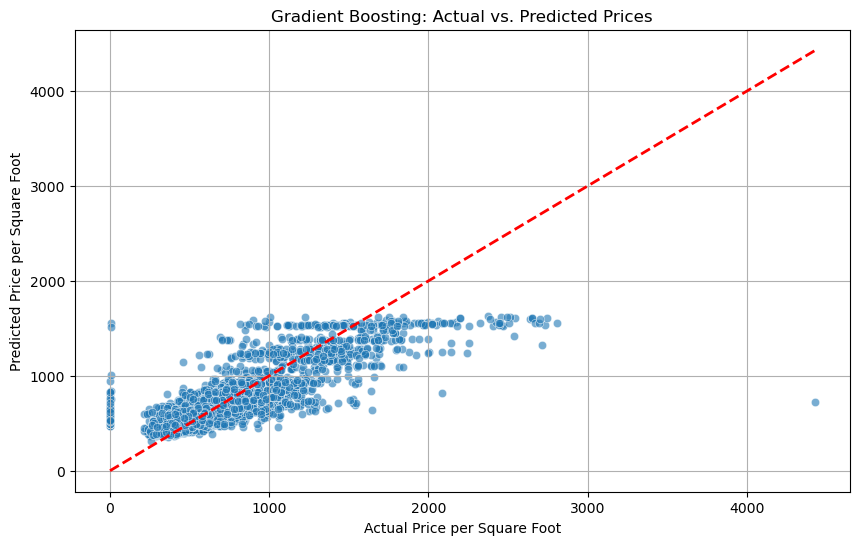

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define features and target
features = ['Size', 'Rooms', 'Bathrooms', 'Car Parks', 'Broad Property Type', 'Location', 'Furnishing']
X = data_cleaned[features]
y = data_cleaned['Price'] / data_cleaned['Size']  # Price per square foot

# Convert features to numeric
X = X.copy()
X['Size'] = pd.to_numeric(X['Size'], errors='coerce')
X['Rooms'] = pd.to_numeric(X['Rooms'], errors='coerce')
X['Bathrooms'] = pd.to_numeric(X['Bathrooms'], errors='coerce')
X['Car Parks'] = pd.to_numeric(X['Car Parks'], errors='coerce')

# Handle categorical features
categorical_features = ['Broad Property Type', 'Location', 'Furnishing']
numeric_features = ['Size', 'Rooms', 'Bathrooms', 'Car Parks']

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline with preprocessing and model training
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

# Drop rows with missing values
X = X.dropna()
y = y[X.index]  # Ensure target and features have the same index

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline_gb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = pipeline_gb.predict(X_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - Mean Squared Error: {mse_gb:.2f}")
print(f"Gradient Boosting - R² Score: {r2_gb:.2f}")

# Make predictions on the test set
y_pred_gb = pipeline_gb.predict(X_test)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.6, edgecolors="w", linewidth=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('Actual Price per Square Foot')
plt.ylabel('Predicted Price per Square Foot')
plt.title('Gradient Boosting: Actual vs. Predicted Prices')
plt.grid(True)
plt.show()

In [36]:
#Export the cleaned data to new CSV file 
data_cleaned.to_csv('cleaned_data.csv', index=False)